In [1]:
## Modeling for predicting 72h ED revisit at ED discharge

SyntaxError: invalid decimal literal (2278424907.py, line 3)

In [ ]:
##Load train and test

In [5]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     / 22.6 MB 15.8 MB/s 0:00:030m
  Preparing metadata (setup.py) ... done


In [43]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from pandas_profiling import ProfileReport
from helpers6 import PlotROCCurve, get_lstm_data_gen

output_path = '/Users/chenyiman/Documents/July23term/healthcareanalytics/Project/TASK3_DROP'
path = output_path


df_train = pd.read_csv((os.path.join(path, 'train_drop.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_drop.csv')))
confidence_interval = 95
random_seed = 0

In [47]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,...,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,2121-01-18 11:11:00,2121-01-18 11:15:00,F,26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,35.444444,90.0,16.0,100.0,139.0,77.0,8.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,60.0,16.0,100.0,101.0,63.0,8.0,0.0,0.0,0,0,0,97.666667,0,0,0,1,1,1
1,2181-04-08 19:14:00,2181-04-09 13:31:00,M,88.0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,18.28,36.722222,88.0,16.0,100.0,109.0,80.0,7.0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,...,1,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.611111,73.0,16.0,95.0,109.0,66.0,0.0,4.0,14.0,0,1,0,89.666667,9,9,6,1,1,1
2,2178-10-23 20:53:00,2178-10-24 06:05:24,F,43.0,1,0,0,0,0,0,0,2,0,0,0,3,0,0,0,9.21,36.555556,69.0,20.0,97.0,126.0,82.0,8.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,36.500000,72.0,18.0,100.0,128.0,91.0,0.0,11.0,14.0,0,0,1,96.666667,3,0,2,0,0,1
3,2174-06-03 17:46:00,2174-06-03 17:53:00,F,55.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,36.666667,69.0,18.0,100.0,138.0,84.0,10.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.055556,75.0,18.0,100.0,137.0,80.0,10.0,2.0,1.0,0,0,0,102.000000,1,4,5,0,0,1
4,2126-10-23 04:58:00,2126-10-23 05:34:00,M,92.0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0.60,36.388889,74.0,10.0,95.0,193.0,77.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.555556,64.0,16.0,94.0,159.0,71.0,0.0,6.0,10.0,0,0,0,115.666667,4,9,9,2,1,0


In [ ]:
#1. task-specific filter: exclude ED death cases for train and test

#for task 3, which & how variable need to be filtered?

In [8]:
df_train = df_train[(df_train['ed_death'] == 0) & (df_train['outcome_inhospital_mortality'] == 0)]
df_test = df_test[(df_test['ed_death'] == 0) & (df_test['outcome_inhospital_mortality'] == 0)]

In [9]:
file = ProfileReport(df_train)
file.to_file(output_file='output_train.html')
profile.to_file('data description_train.html')

Summarize dataset: 100%|▉| 1200/1203 [02:15<00:01,  1.74it/s, Detecting duplicat/opt/homebrew/Caskroom/miniforge/base/envs/env_chenyimane/lib/python3.11/site-packages/ydata_profiling/model/pandas/duplicates_pandas.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .reset_index(name=duplicates_key)
/opt/homebrew/Caskroom/miniforge/base/envs/env_chenyimane/lib/python3.11/site-packages/ydata_profiling/model/pandas/duplicates_pandas.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .reset_index(name=duplicates_key)
/opt/homebre

NameError: name 'profile' is not defined

In [ ]:
file = ProfileReport(df_test)
file.to_file(output_file='output_test.html')
profile.to_file('data description_test.html')

In [ ]:
### 2. Variable Selection

In [3]:
variable = ["age", "gender", "intime_ed", "outtime_ed", 
            #"outcome_hospitalization", 
            "outcome_icu_transfer_12h", 
            #"outcome_critical",
            
            
            "n_ed_30d", 
            #"n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", 
            #"n_icu_90d", "n_icu_365d", 
            "ed_los_hours",
            "triage_temperature",
            #"triage_pain", 
            "triage_acuity", 
            #"triage_heartrate",
            "triage_resprate","triage_o2sat",
            #"triage_sbp",'triage_MAP',
            "triage_dbp",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", 
            #"cci_CHF", 
            "cci_PVD", 
            "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", 
            #"cci_DM1", 
            "cci_DM2", 
            "cci_Paralysis",
            #"cci_Renal", "cci_Cancer1",  "cci_Cancer2", 
            "cci_HIV","cci_Liver2",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN", 
            #"eci_HTN1", "eci_HTN2",  
            #"eci_CHF",
           #"eci_PVD", "eci_Pulmonary",
            #"eci_Paralysis",
            #"eci_DM1",
            #"eci_DM2",
            #"eci_Renal",
            #"eci_Liver","eci_PUD",
            #"eci_HIV",
            #"eci_Tumor2",
            "eci_Tumor1",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            #"eci_Rheumatic",
            "eci_Obesity", "eci_WeightLoss", 
            #"eci_FluidsLytes",
            "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses"]

outcome = "outcome_ed_revisit_3d"

In [4]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [5]:
X_train.dtypes.to_frame().T

,age,gender,intime_ed,outtime_ed,outcome_icu_transfer_12h,n_ed_30d,n_hosp_365d,n_icu_30d,ed_los_hours,triage_temperature,...,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses
0,float64,object,object,object,int64,int64,int64,int64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [6]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [7]:
X_train['intime_ed']=pd.to_datetime(X_train['intime_ed']).dt.hour
X_test['intime_ed']=pd.to_datetime(X_test['intime_ed']).dt.hour
X_train['intime_ed']
X_test['intime_ed']

0        16
1        18
2         2
3        16
4        21
         ..
68342    12
68343    10
68344    19
68345     4
68346    17
Name: intime_ed, Length: 68347, dtype: int32

In [8]:
X_train['outtime_ed']=pd.to_datetime(X_train['outtime_ed']).dt.hour
X_test['outtime_ed']=pd.to_datetime(X_test['outtime_ed']).dt.hour
X_train['outtime_ed']
X_test['outtime_ed']

0         5
1        16
2         2
3        17
4         2
         ..
68342    22
68343    10
68344     0
68345     4
68346     0
Name: outtime_ed, Length: 68347, dtype: int32

In [27]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [28]:
###3.1 decision tree & feature importance
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9298432996327564


In [30]:
FI = clf.feature_importances_
df = pd.DataFrame({'Feature':X_train.columns,'Importances':FI}).sort_values(by = "Importances",ascending = False)
df

,Feature,Importances
8,ed_los_hours,0.140626
0,age,0.119314
13,triage_dbp,0.117490
9,triage_temperature,0.098866
2,intime_ed,0.062338
3,outtime_ed,0.061712
5,n_ed_30d,0.051468
12,triage_o2sat,0.049509
11,triage_resprate,0.048175
6,n_hosp_365d,0.034234


In [31]:
list(df['Feature'][0:])


['ed_los_hours',
 'age',
 'triage_dbp',
 'triage_temperature',
 'intime_ed',
 'outtime_ed',
 'n_ed_30d',
 'triage_o2sat',
 'triage_resprate',
 'n_hosp_365d',
 'triage_acuity',
 'gender',
 'cci_Pulmonary',
 'chiefcom_headache',
 'chiefcom_chest_pain',
 'chiefcom_abdominal_pain',
 'eci_Alcohol',
 'chiefcom_back_pain',
 'eci_Tumor1',
 'chiefcom_nausea_vomiting',
 'eci_Obesity',
 'eci_Arrhythmia',
 'eci_NeuroOther',
 'cci_Stroke',
 'eci_Psychoses',
 'eci_Hypothyroid',
 'eci_Drugs',
 'cci_Liver1',
 'cci_MI',
 'chiefcom_dizziness',
 'cci_DM2',
 'eci_WeightLoss',
 'cci_PVD',
 'eci_Anemia',
 'eci_Coagulopathy',
 'chiefcom_syncope',
 'chiefcom_cough',
 'eci_Valvular',
 'chiefcom_fever_chills',
 'cci_HIV',
 'cci_Rheumatic',
 'eci_PHTN',
 'cci_PUD',
 'cci_Dementia',
 'eci_BloodLoss',
 'eci_Lymphoma',
 'cci_Liver2',
 'cci_Paralysis',
 'outcome_icu_transfer_12h',
 'chiefcom_shortness_of_breath',
 'n_icu_30d']

In [32]:
new_variable = ['ed_los_hours',
 'age',
 'triage_dbp',
 'triage_temperature',
 'outtime_ed',
 'intime_ed',
 'n_ed_30d',
 'triage_resprate',
 'triage_o2sat',
 'n_hosp_365d',
 'triage_acuity',
 'gender'
]

In [33]:
X_train2 = X_train[new_variable]
X_test2=X_test[new_variable]

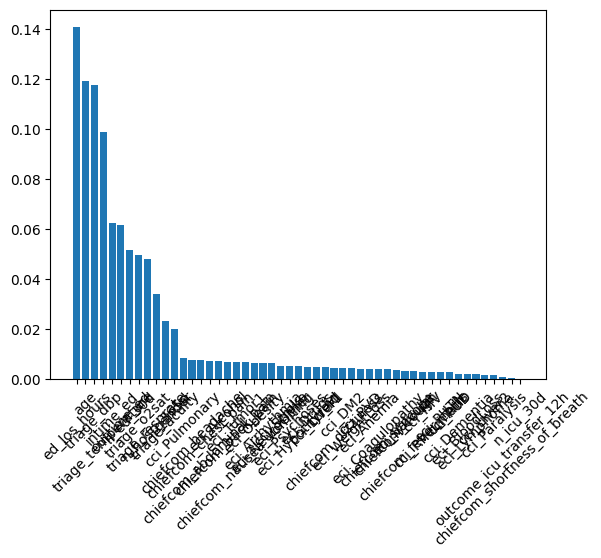

In [34]:
plt.bar(df['Feature'],df['Importances'])
plt.xticks(rotation=45)
plt.show()

In [35]:
###3. Modeling script
# Containers for all results
result_list = []

Logistic Regression:


/opt/homebrew/Caskroom/miniforge/base/envs/env_chenyimane/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 1.1601660251617432 seconds
AUC: 0.6691160758360176
AUPRC: 0.13042997654252542
Sensitivity: 0.5969230769230769
Specificity: 0.630176171449328
Score thresold: 0.0307257519285986
2.5 97.5


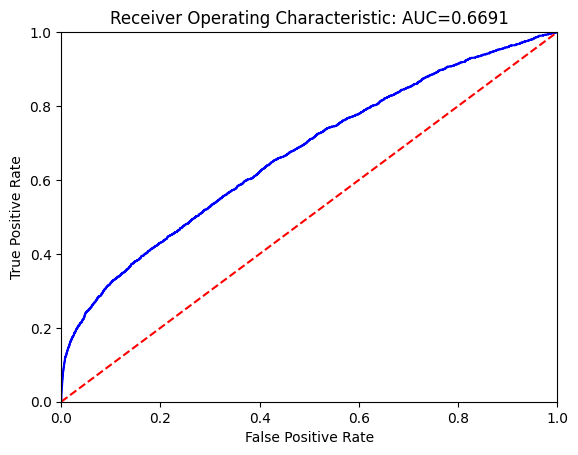

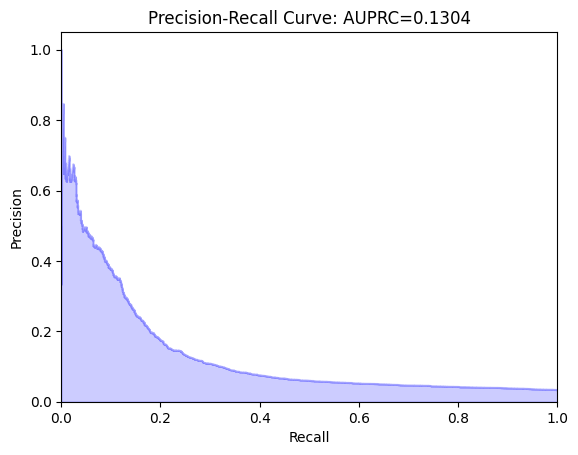

In [36]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train2,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 23.217031955718994 seconds
AUC: 0.6774233736356876
AUPRC: 0.12075558379280238
Sensitivity: 0.6008791208791209
Specificity: 0.6449328005811842
Score thresold: 0.04
2.5 97.5


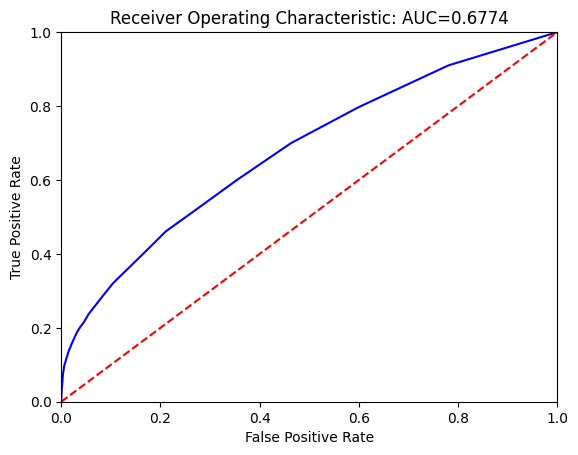

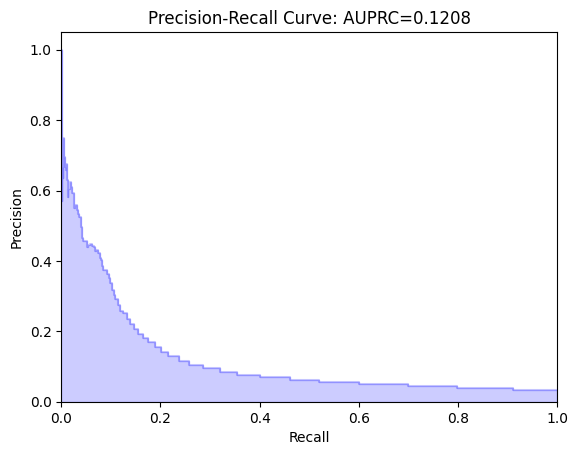

[0.16035227 0.14150038 0.14526696 0.12919557 0.0778194  0.0779924
 0.050283   0.06146413 0.06096913 0.05384542 0.0223877  0.01892364]


In [39]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train2,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 19.63627600669861 seconds
AUC: 0.7315565503633066
AUPRC: 0.14719803536386536
Sensitivity: 0.6527472527472528
Specificity: 0.6694363724421843
Score thresold: 0.03270893881186922
2.5 97.5


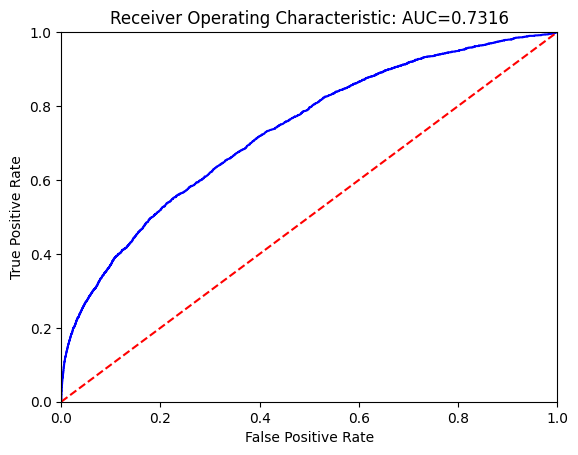

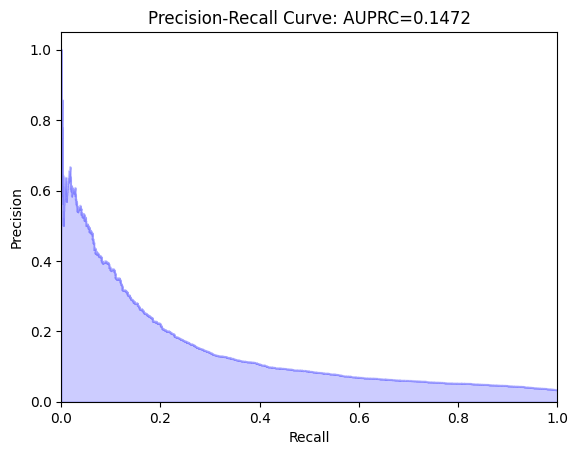

In [40]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train2, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

XGBoosting:
Training time: 4.483541965484619 seconds
AUC: 0.7211082182740374
AUPRC: 0.13686869538968752
Sensitivity: 0.6632967032967033
Specificity: 0.638621503814021
Score thresold: 0.030551197
2.5 97.5


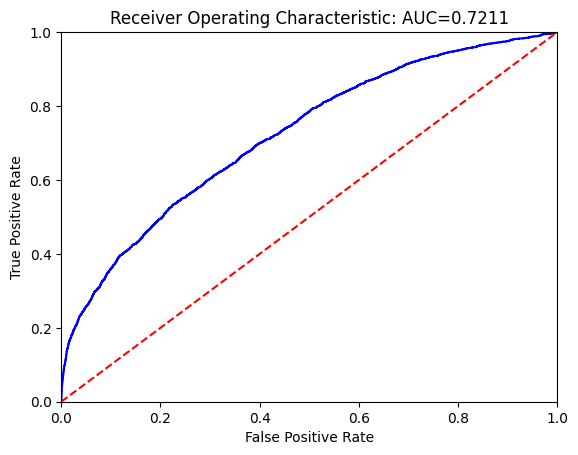

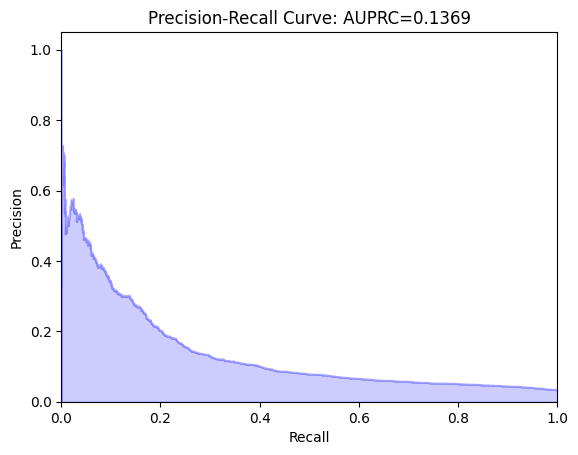

In [41]:
print("XGBoosting:")
import xgboost as xgb
xgb = xgb.XGBClassifier()
start = time.time()
xgb.fit(X_train2, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = xgb.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["XGB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [44]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [48]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train2.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

Epoch 1/20
1367/1367 [==============================] - 1s 566us/step - loss: 0.1429 - accuracy: 0.9663 - auc: 0.6364 - auprc: 0.1102 - true_positives: 345.0000 - true_negatives: 263842.0000 - precision: 0.4964 - recall: 0.0375
Epoch 2/20
1367/1367 [==============================] - 1s 579us/step - loss: 0.1372 - accuracy: 0.9666 - auc: 0.6720 - auprc: 0.1287 - true_positives: 357.0000 - true_negatives: 263894.0000 - precision: 0.5450 - recall: 0.0388
Epoch 3/20
1367/1367 [==============================] - 1s 576us/step - loss: 0.1354 - accuracy: 0.9666 - auc: 0.6902 - auprc: 0.1342 - true_positives: 368.0000 - true_negatives: 263894.0000 - precision: 0.5526 - recall: 0.0400
Epoch 4/20
1367/1367 [==============================] - 1s 583us/step - loss: 0.1347 - accuracy: 0.9667 - auc: 0.6933 - auprc: 0.1401 - true_positives: 363.0000 - true_negatives: 263923.0000 - precision: 0.5744 - recall: 0.0395
Epoch 5/20
1367/1367 [==============================] - 1s 577us/step - loss: 0.1343 - a

INFO:tensorflow:Assets written to: 72h_ed_revisit_mlp/assets


MLP:
2136/2136 [==============================] - 0s 197us/step
AUC: 0.7255057320086379
AUPRC: 0.14576263111913634
Sensitivity: 0.6597802197802198
Specificity: 0.6512289623441094
Score thresold: 0.04289846
2.5 97.5


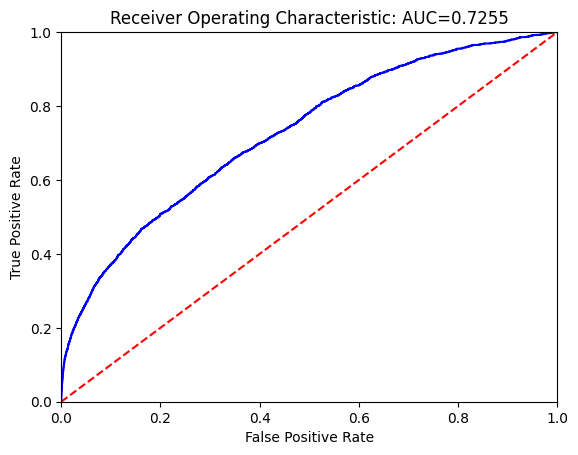

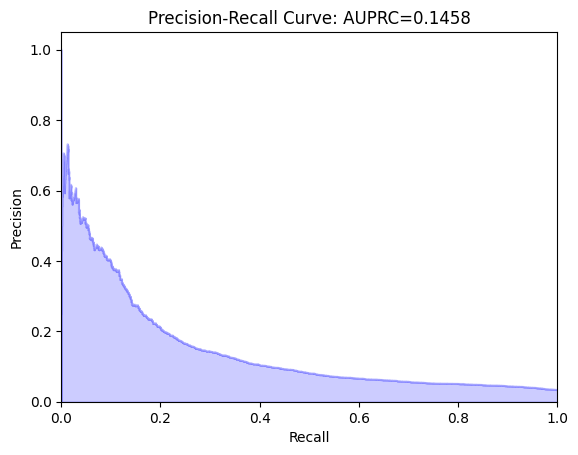

In [49]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test2.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
#performance output

In [50]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.031,0.669 (0.656-0.676),0.13 (0.119-0.139),0.597 (0.563-0.639),0.63 (0.586-0.666),1.160
1,RF,0.040,0.69 (0.678-0.699),0.132 (0.119-0.14),0.615 (0.603-0.631),0.656 (0.654-0.659),26.566
2,RF,0.040,0.677 (0.668-0.686),0.121 (0.11-0.128),0.601 (0.585-0.61),0.645 (0.641-0.649),23.217
3,GB,0.033,0.732 (0.723-0.742),0.147 (0.136-0.155),0.653 (0.636-0.693),0.669 (0.623-0.692),19.636
4,XGB,0.031,0.721 (0.71-0.732),0.137 (0.126-0.145),0.663 (0.611-0.68),0.639 (0.626-0.693),4.484
5,MLP,0.043,0.726 (0.716-0.732),0.146 (0.133-0.152),0.66 (0.62-0.666),0.651 (0.644-0.68),15.966


In [51]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.160352
2,intime_ed,0.145267
1,gender,0.141500
3,outtime_ed,0.129196
5,n_ed_30d,0.077992
4,outcome_icu_transfer_12h,0.077819
7,n_icu_30d,0.061464
8,ed_los_hours,0.060969
9,triage_temperature,0.053845
6,n_hosp_365d,0.050283
